Download Missouri Camera Trap Image

`aws s3 cp --recursive --no-sign-request "s3://us-west-2.opendata.source.coop/agentmorris/lila-wildlife/missouricameratraps/images" "./images"`

In [92]:
JSON_PATH = "missouri_camera_traps_set1.json"

In [1]:
import numpy as np
from PIL import Image

def check_greyscale(img, threshold=1):
    arr = np.asarray(img, dtype=np.float32)
    diff_rg = np.abs(arr[...,0] - arr[...,1])
    diff_rb = np.abs(arr[...,0] - arr[...,2])
    diff_gb = np.abs(arr[...,1] - arr[...,2])
    mean_diff = (diff_rg.mean() + diff_rb.mean() + diff_gb.mean()) / 3.0
    return mean_diff < threshold

In [104]:
import json
with open(JSON_PATH, 'r') as f:
    ann = json.load(f)

ann_img = ann["images"]
train_idx = []
test_idx = []
for i, img_info in enumerate(ann_img):
    if "n_boxes" in img_info.keys():
        test_idx.append(i)
    else:
        train_idx.append(i)

np.random.seed(0)
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

# from sklearn.model_selection import train_test_split
# train_idx, test_idx = train_test_split(range(len(ann["images"])), test_size=0.2, random_state=42)

In [ ]:
import os
from torch.utils.data import Dataset
import torchvision.transforms as T

class CCTDataset(Dataset):
    """
    Unpaired dataset loader for Caltech Camera Traps for CycleGAN-style training.
    Domain A / Domain B splitting is done by image path or metadata.
    """
    def __init__(self,
                 image_dir: str,
                 json_path: str,
                 num_samples: int = None,
                 transform: T.Compose = None,
                 image_size: int = 1024,
                 mode: str = 'train'):
        """
        Args:
          image_dir: root directory containing image files (subfolders or flat).
          json_path: full path to COCO-style JSON file with metadata.
          transform: torchvision transforms to apply.
          image_size: target size (will do Resize + CenterCrop or so).
          mode: 'train' or 'val' (if you want different behavior).
        """
        super().__init__()
        self.image_dir = image_dir
        self.transform = transform or T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.mode = mode

        # Load the annotation JSON
        with open(json_path, 'r') as f:
            ann = json.load(f)

        # Build image info list
        # Each item: {'file_name': ..., 'location': <int or str>, ...}
        images_info = ann['images']

        # Filter images by location into two domains
        self.grey_img = []
        self.len_grey = 0
        self.col_img = []
        self.len_col = 0
        self.grey_img_cat = []

        if mode == "train":
            selected_indices = train_idx
        else:
            selected_indices = test_idx

        for idx in selected_indices:
            img_info = images_info[idx]
            # full path
            fn = img_info['file_name']
            full_path = os.path.join(image_dir, fn)
            if not os.path.isfile(full_path):
                # skip missing files
                continue
            if check_greyscale(Image.open(full_path)):
                if num_samples is None or self.len_grey < num_samples:
                    self.grey_img_cat.append(1 if "bbox" in img_info.keys() else 0)
                    self.grey_img.append(full_path)
                    self.len_grey += 1
            else:
                if num_samples is None or self.len_col < num_samples:
                    self.col_img.append(full_path)
                    self.len_col += 1
            if num_samples is None:
                continue
            elif self.len_col >= num_samples and self.len_grey >= num_samples:
                break

        self.dataset_length = max(self.len_grey, self.len_col)
        print(f"Greyscale img count: {self.len_grey}, Colour img count: {self.len_col}, using dataset length {self.dataset_length}")
        
    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        # For unpaired: sample A and B independently (or aligned by idx mod list length)
        pathA = self.grey_img[idx % self.len_grey]
        pathB = self.col_img[idx % self.len_col]
        catA = self.grey_img_cat[idx % self.len_grey]

        img_grey = Image.open(pathA).convert('RGB')
        img_col = Image.open(pathB).convert('RGB')

        img_grey = self.transform(img_grey)
        img_col = self.transform(img_col)

        return img_grey, img_col, catA

In [86]:
train_dataset = CCTDataset(
    image_dir= "images",
    json_path= JSON_PATH,
    num_samples=1024,
    image_size=512
)

KeyboardInterrupt: 

In [106]:
test_dataset = CCTDataset(
    image_dir= "images",
    json_path= JSON_PATH,
    num_samples=32,
    image_size=512,
    mode="test"
)

Greyscale img count: 32, Colour img count: 32, using dataset length 32


In [107]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image

# =========================================================
# 1️⃣ U-Net Generator
# =========================================================
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.block(x)
        if self.use_dropout:
            x = self.dropout(x)
        return x


class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down1 = UNetBlock(in_channels, 64, down=True)
        self.down2 = UNetBlock(64, 128, down=True)
        self.down3 = UNetBlock(128, 256, down=True)
        self.down4 = UNetBlock(256, 512, down=True, use_dropout=True)
        self.down5 = UNetBlock(512, 512, down=True, use_dropout=True)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 512, 4, 2, 1),
            nn.ReLU(inplace=True)
        )

        self.up1 = UNetBlock(512, 512, down=False, use_dropout=True)
        self.up2 = UNetBlock(1024, 512, down=False, use_dropout=True)
        self.up3 = UNetBlock(1024, 256, down=False)
        self.up4 = UNetBlock(512, 128, down=False)
        self.up5 = UNetBlock(256, 64, down=False)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        bottleneck = self.bottleneck(d5)
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d5], 1))
        u3 = self.up3(torch.cat([u2, d4], 1))
        u4 = self.up4(torch.cat([u3, d3], 1))
        u5 = self.up5(torch.cat([u4, d2], 1))
        out = self.final(torch.cat([u5, d1], 1))
        return out


In [11]:

# =========================================================
# 2️⃣ PatchGAN Discriminator
# =========================================================
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, 4, 1, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 1, 4, 1, 1)
        )

    def forward(self, x):
        return self.model(x)


In [12]:
# ================================================
# 3️⃣ Setup
# ================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

G_XtoY = UNetGenerator().to(device)
G_YtoX = UNetGenerator().to(device)
D_X = PatchDiscriminator().to(device)
D_Y = PatchDiscriminator().to(device)

# Losses
adv_criterion = nn.MSELoss()
cycle_criterion = nn.L1Loss()

# Optimizers
opt_G = optim.Adam(
    list(G_XtoY.parameters()) + list(G_YtoX.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)
opt_D = optim.Adam(
    list(D_X.parameters()) + list(D_Y.parameters()),
    lr=2e-4, betas=(0.5, 0.999)
)

cuda


In [ ]:
from tqdm import tqdm
# =========================================================
# 6️⃣ Training Loop
# =========================================================
n_epochs = 10
lambda_cycle = 10.0

for epoch in range(n_epochs):
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{n_epochs}]")
    for real_X, real_Y in loop:
        real_X, real_Y = real_X.to(device), real_Y.to(device)

        # -----------------------
        #  Train Generators
        # -----------------------
        opt_G.zero_grad()

        fake_Y = G_XtoY(real_X)
        fake_X = G_YtoX(real_Y)

        # Adversarial losses
        loss_G_adv_Y = adv_criterion(D_Y(fake_Y), torch.ones_like(D_Y(fake_Y)))
        loss_G_adv_X = adv_criterion(D_X(fake_X), torch.ones_like(D_X(fake_X)))
        loss_G_adv = (loss_G_adv_X + loss_G_adv_Y)

        # Cycle-consistency
        recov_X = G_YtoX(fake_Y)
        recov_Y = G_XtoY(fake_X)
        loss_cycle = cycle_criterion(recov_X, real_X) + cycle_criterion(recov_Y, real_Y)

        # Total Generator Loss
        loss_G = loss_G_adv + lambda_cycle * loss_cycle
        loss_G.backward()
        opt_G.step()

        # -----------------------
        #  Train Discriminators
        # -----------------------
        opt_D.zero_grad()

        # D_X
        loss_D_X_real = adv_criterion(D_X(real_X), torch.ones_like(D_X(real_X)))
        loss_D_X_fake = adv_criterion(D_X(fake_X.detach()), torch.zeros_like(D_X(fake_X)))
        loss_D_X = (loss_D_X_real + loss_D_X_fake) * 0.5

        # D_Y
        loss_D_Y_real = adv_criterion(D_Y(real_Y), torch.ones_like(D_Y(real_Y)))
        loss_D_Y_fake = adv_criterion(D_Y(fake_Y.detach()), torch.zeros_like(D_Y(fake_Y)))
        loss_D_Y = (loss_D_Y_real + loss_D_Y_fake) * 0.5

        # Total Discriminator Loss
        loss_D = loss_D_X + loss_D_Y
        loss_D.backward()
        opt_D.step()

        loop.set_postfix({
            "loss_G": f"{loss_G.item():.3f}",
            "loss_D": f"{loss_D.item():.3f}"
        })

        # ==============================
        # Logging
        # ==============================

    # Save example outputs
    save_image(real_X, f"out/real_X_epoch{epoch}.png")
    save_image(fake_Y, f"out/fake_Y_epoch{epoch}.png")
    save_image(recov_X, f"out/rec_X_epoch{epoch}.png")


Epoch [10/10]: 100%|██████████| 256/256 [09:36<00:00,  2.25s/it, loss_G=3.459, loss_D=0.051]


In [15]:
torch.save(G_XtoY.state_dict(), "model/G_XtoY.pth")
torch.save(G_YtoX.state_dict(), "model/G_YtoX.pth")
torch.save(D_X.state_dict(), "model/D_X.pth")
torch.save(D_Y.state_dict(), "model/D_Y.pth")

In [13]:
G_XtoY.load_state_dict(torch.load("model/G_XtoY.pth"))
G_YtoX.load_state_dict(torch.load("model/G_YtoX.pth"))
D_X.load_state_dict(torch.load("model/D_X.pth"))
D_Y.load_state_dict(torch.load("model/D_Y.pth"))

<All keys matched successfully>

In [18]:

from megadetector.detection import run_detector
from megadetector.visualization import visualization_utils as vis_utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
detector = run_detector.load_detector('MDV5A')

Model v5a.0.1 already exists and is valid at C:\Users\aidan\AppData\Local\Temp\megadetector_models\md_v5a.0.1.pt
PyTorch reports 1 available CUDA devices
GPU available: True


c:\Users\aidan\anaconda3\envs\wildlife-da\Lib\site-packages\yolov5\utils\general.py:31: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources as pkg


Loading PT detector with compatibility mode classic
Loaded image size 1280 from model metadata
Using model stride: 64
PTDetector using device cuda:0


Fusing layers... 
Fusing layers... 
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs
Model summary: 733 layers, 140054656 parameters, 0 gradients, 208.8 GFLOPs


In [122]:
cat_map = {"1": "Animal", "2": "Person", "3": 'Vehicle'}

def draw_result(img, result, path, display=False):
    fig, ax = plt.subplots()
    ax.imshow(img)
    for det in result:
        x1, y1, w, h = np.array(det["bbox"]) * 512
        acc = det["conf"]
        cat = cat_map[det["category"]]
        rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='red', facecolor='none')
        ax.text(x1+7, y1-10, f"{cat}: {acc*100:.1f}%", color="black", fontsize=8, backgroundcolor="red")
        ax.add_patch(rect)
    ax.axis("off")
    plt.savefig(path, bbox_inches="tight", pad_inches=0)
    if display:
        plt.show()
    else:
        plt.close()

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])
Bounding box count: 1
Found 0 detections above threshold for grey image
Found 0 dete

KeyboardInterrupt: 

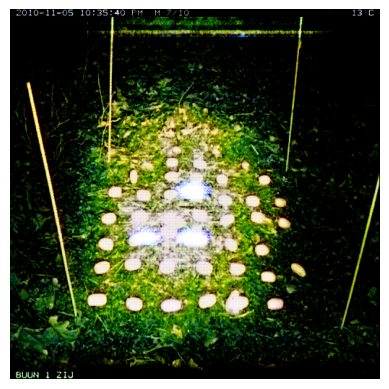

In [129]:
os.makedirs("eval", exist_ok=True)
guess_X = [0, 0, 0, 0] # TN FN FP TP
guess_Y = [0, 0, 0, 0]
threshold = 0.25
for i, (real_X, real_Y, cat_X) in enumerate(test_loader):
    save_image(real_X, f"eval/{i:02d}_real_X.png")
    fake_Y = G_XtoY(real_X.to(device))
    save_image(fake_Y, f"eval/{i:02d}_fake_Y.png")
    
    img_X = vis_utils.load_image(f"eval/{i:02d}_real_X.png")
    img_Y = vis_utils.load_image(f"eval/{i:02d}_fake_Y.png")

    result_X = detector.generate_detections_one_image(img_X)
    result_Y = detector.generate_detections_one_image(img_Y)
    count = cat_X.cpu().numpy()[0]
    print(f"Bounding box count: {count}")
    det_X = [d for d in result_X['detections'] if d['conf'] > threshold]
    print('Found {} detections above threshold for grey image'.format(len(det_X)))
    # print(det_X)
    draw_result(img_X, det_X, f"eval/{i:02d}_real_X.png", )

    det_Y = [d for d in result_Y['detections'] if d['conf'] > threshold]
    print('Found {} detections above threshold for generated image'.format(len(det_Y)))
    # print(det_Y)
    draw_result(img_Y, det_Y, f"eval/{i:02d}_fake_Y.png")

    guess_X[(len(det_X) > 0)*2+(count > 0)] += 1
    guess_Y[(len(det_Y) > 0)*2+(count > 0)] += 1


In [ ]:
total = len(test_loader)
print(f"Accuracy on real grey images: {(guess_X[0]+guess_X[3])/total:.3f}")
print(f"Precision on real grey images: {guess_X[3]/(guess_X[2]+guess_X[3]):.3f}")
print(f"Recall on real grey images: {guess_X[3]/(guess_X[1]+guess_X[3]):.3f}")
print(f"Accuracy on generated images: {(guess_Y[0]+guess_Y[3])/total:.3f}")
print(f"Precision on generated images: {guess_Y[3]/(guess_Y[2]+guess_Y[3]):.3f}")
print(f"Recall on generated images: {guess_Y[3]/(guess_Y[1]+guess_Y[3]):.3f}")

Accuracy on real grey images: 0.438
Precision on real grey images: 1.000
Recall on real grey images: 0.217
Accuracy on generated images: 0.625
Precision on generated images: 1.000
Recall on generated images: 0.478
